# Song Recommendation System Project - Main Notebook
### Justin Gong | June 2023

The following is a personal project which aims to create a recommendation system in Python through taking in an inputted playlist and returning a list of potential song recommendations. This will be achieved through constructing a K-Nearest Neighbors machine learning model using euclidean distance to identify similar songs. I will also explore alternative options such as calculating the Pearson correlation coefficient between songs and using cosine similarity in high dimensional space. We will test various algorithms to determine potential song recommendations and perform user-based statistical testing to determine which model performs the best. This is an original project developed in order to learn about potential recommendation methods and practice having a user-experience orientated approach to a project. Below is a table of contents which outlines the general process in developing the model. 

## Table of Contents 
1. Data Preprocessing 
2. Model Constructing 
    - kNN Model
        - Approach 1: Aggregating Audio Features 
        - Approach 2: Individual Audio Features 
    - Constructing Error Metric and Recommendation Scores
3. Refining Model Accuracy 
    - Popularity Score 
    - Genre & Artist Analysis
    - Spotipy System
    - Pearson Correlation
4. Deployment and Conclusions
    - Final Model & Testing
    - Takeaways

## Importing Libraries

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import re

from sklearn.neighbors import NearestNeighbors

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# 1. Data Preprocessing

I first create an API using Spotify to access music data. This is necessary in order to retrieve playlist information and audio features. 

In [16]:
client_id = '87b954ab1feb456d860986363851e7b0'
client_secret = 'ead8e4be77ef4de583cd8474c95c0ab8'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Next, I'll import and inspect a dataset to act as a song bank. This will primarily be where songs are retrieved. This dataset was retrieved from the following 

In [3]:
df = pd.read_csv("data/SpotifyAudioFeaturesApril2019.csv")

In [7]:
df.head()

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641,0
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928,0


## Exploratory Data Analysis

**Inspecting NA Values**

In [9]:
np.sum(df.isna())

artist_name         0
track_id            0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
popularity          0
dtype: int64

This dataset has no NA values to remove

## Univariate Analysis

First, we'll analyze the artists that are in our dataset. We first look at the most commonly occuring artists in our dataset. 

Text(0, 0.5, 'Frequency')

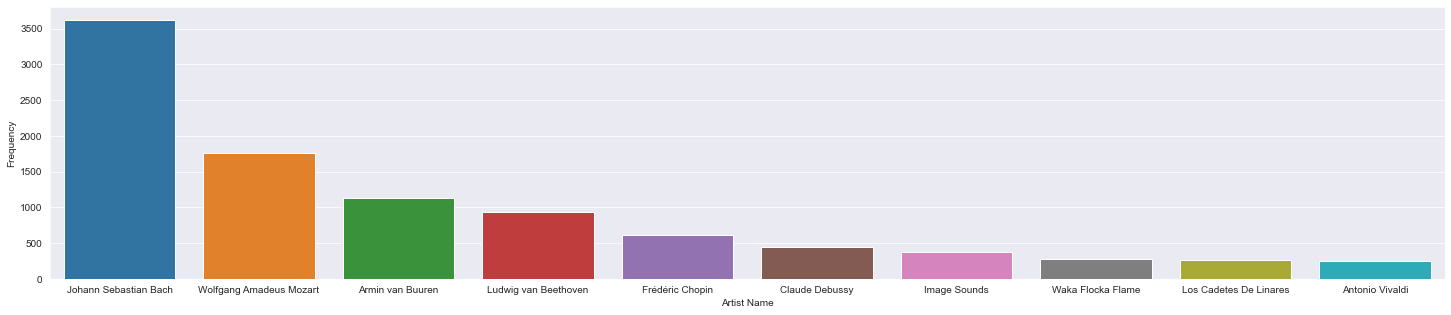

In [44]:
sns.set_style("darkgrid")
plt.figure(figsize = (25, 5))
sns.barplot(x = df["artist_name"].value_counts().head(10).index,
           y = df["artist_name"].value_counts().head(10))
plt.xlabel("Artist Name")
plt.ylabel("Frequency")

Next, we'll look at the most popular artists that are in our dataset.

In [59]:
df.groupby("artist_name").mean().sort_values("popularity", ascending = False).head(12)["popularity"]

artist_name
Jonas Brothers     91.000000
Don Patricio       86.000000
Rammstein          84.000000
Guaynaa            84.000000
Paloma Mami        82.333333
DJ Luian           81.333333
XO Cupid           81.000000
PDL                81.000000
Lil Nas X          81.000000
Louis Tomlinson    81.000000
MC L da Vinte      81.000000
Lil Dicky          81.000000
Name: popularity, dtype: float64

In [64]:
df["artist_name"].nunique()

34621

There are over 34k unique artists and a total of 130k total songs. Therefore, each artist averages approximately 4 songs in this dataset. 

Next, we'll analyze the numerical data in this dataset. 

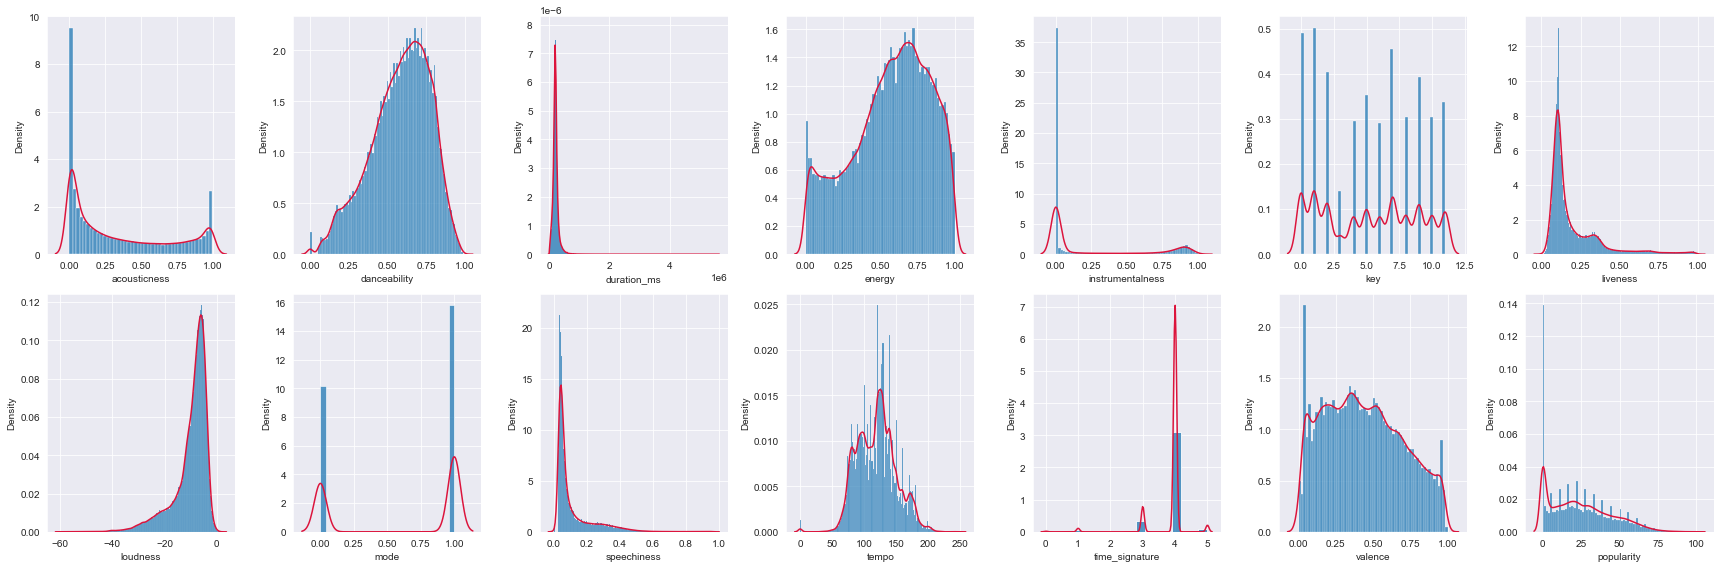

In [82]:
numerical_features = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature",
                     "valence", "popularity"]
plt.figure(figsize = (24, 8))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 7, (i + 1))
    sns.histplot(df[feature], stat = "density")
    sns.kdeplot(df[feature], color = "crimson")
plt.tight_layout()
plt.show()

**Takeaways** 
- Certain features such as `dancebility`, `energy`, and `tempo` seem to be generally normally distributed and unimodal. Therefore, I anticipate that songs with particularly high or low values in these categories may generate more accurate predictions because they are more unique. 
- `mode` only has two values, that being 0 and 1
- There are many unknown artists in my dataset (at least to myself) which may influence the results. However, 130k songs should be enough to provide music recommendations ranging a large audience.
- Certain features such as `loudness`, `duration_ms`, `speechiness`, and `liveliness` seem to be right skewed. This means the majority of the songs fall under a certain range. Therefore, I anticipate that if I am making recommendations for songs that have particularly high values in these categories, it may be more accurate. 
- There are some uniform distributions which may be beneficial when making recommendations.

We will be dropping certain features that should not be relevant in making recommendations. 

In [5]:
df_model = df.drop(columns = ["artist_name", "track_id", "track_name", "popularity", "duration_ms"])

In [86]:
df_model.head()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.005820,0.743,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118
1,0.024400,0.846,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.371
2,0.025000,0.603,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.382
3,0.029400,0.800,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.641
4,0.000035,0.783,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.928


In [18]:
desired_features = numerical_features = ["acousticness", "danceability", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature",
                                         "valence"]

## Model Construction

NOTE: We do not need to perform standard scaling because we are not making predictions using the dataset, therefore we are not concerned with the data being normal and standardized. Instead, we are using this dataset to find the closest points to an input. Therefore, StandardScaler is not necessary.

We will first fit the NearestNeighbors model to the dataset. 

In [6]:
knn_model = NearestNeighbors(n_neighbors = 50, algorithm = "auto").fit(df_model)

In creating this model, we will try two different methods: 
1. Averages for songs in a playlist and finding nearest neighbors using averaged song (efficient for large playlists)
2. Finding song recommendations for each individual song in a playlist and keeping overlapping songs (inefficient but potentially more accurate)

**1. Averaged Audio Features**

First, we need to create a pipeline that'll return a vector of desired features from a spotify playlist link. 

We will experiment with this playlist: https://open.spotify.com/playlist/051jo7zqACBu3SkVqecs7u?si=8ffc7e5eac354bae

In [7]:
playlist_uri = "https://open.spotify.com/playlist/051jo7zqACBu3SkVqecs7u?si=8ffc7e5eac354bae".split("?")[0][34:]
sp.playlist_tracks(playlist_uri)["items"][0]["track"]["name"]

'Time of Our Lives'

This shows that the first song in the playlist is "Time of Our Lives". We will now use this feature to create the desired dataframe of audio features.

In [221]:
playlist_tracks = []
audio_features = []

for tracks in sp.playlist_tracks(playlist_uri)["items"]:
    playlist_tracks.append(tracks["track"]["id"])
    
for i in range(0, len(playlist_tracks), 100):
    ids = playlist_tracks[i:i + 100]
    audio_features.extend(sp.audio_features(ids))
    
pd.DataFrame(audio_features).head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.729,0.801,5,-5.698,0,0.0529,0.08950,0.000000,0.7660,0.764,123.995,audio_features,6SEizXg6WimNyK8NdI9biV,spotify:track:6SEizXg6WimNyK8NdI9biV,https://api.spotify.com/v1/tracks/6SEizXg6WimN...,https://api.spotify.com/v1/audio-analysis/6SEi...,229347,4
1,0.713,0.802,4,-7.055,1,0.0561,0.04350,0.003770,0.3090,0.343,100.001,audio_features,3vv9phIu6Y1vX3jcqaGz5Z,spotify:track:3vv9phIu6Y1vX3jcqaGz5Z,https://api.spotify.com/v1/tracks/3vv9phIu6Y1v...,https://api.spotify.com/v1/audio-analysis/3vv9...,226739,4
2,0.711,0.700,1,-4.805,0,0.0460,0.00498,0.000125,0.2150,0.801,128.001,audio_features,7EQGXaVSyEDsCWKmUcfpLk,spotify:track:7EQGXaVSyEDsCWKmUcfpLk,https://api.spotify.com/v1/tracks/7EQGXaVSyEDs...,https://api.spotify.com/v1/audio-analysis/7EQG...,211920,4
3,0.700,0.709,7,-5.006,1,0.0838,0.00480,0.000000,0.0290,0.624,122.019,audio_features,1gv4xPanImH17bKZ9rOveR,spotify:track:1gv4xPanImH17bKZ9rOveR,https://api.spotify.com/v1/tracks/1gv4xPanImH1...,https://api.spotify.com/v1/audio-analysis/1gv4...,202960,4
4,0.590,0.642,7,-3.870,1,0.1220,0.07710,0.000000,0.1050,0.651,107.356,audio_features,0qc4QlcCxVTGyShurEv1UU,spotify:track:0qc4QlcCxVTGyShurEv1UU,https://api.spotify.com/v1/tracks/0qc4QlcCxVTG...,https://api.spotify.com/v1/audio-analysis/0qc4...,174444,4
5,0.755,0.837,2,-2.718,0,0.1420,0.09910,0.000000,0.2890,0.714,120.028,audio_features,0HPD5WQqrq7wPWR7P7Dw1i,spotify:track:0HPD5WQqrq7wPWR7P7Dw1i,https://api.spotify.com/v1/tracks/0HPD5WQqrq7w...,https://api.spotify.com/v1/audio-analysis/0HPD...,199693,4
6,0.747,0.716,11,-2.457,0,0.0750,0.13500,0.000000,0.2510,0.751,125.008,audio_features,2EBCVPNAG46nbgs6jXPGvv,spotify:track:2EBCVPNAG46nbgs6jXPGvv,https://api.spotify.com/v1/tracks/2EBCVPNAG46n...,https://api.spotify.com/v1/audio-analysis/2EBC...,210627,4
7,0.652,0.698,10,-4.667,0,0.0420,0.00112,0.000115,0.0886,0.470,96.021,audio_features,3E7dfMvvCLUddWissuqMwr,spotify:track:3E7dfMvvCLUddWissuqMwr,https://api.spotify.com/v1/tracks/3E7dfMvvCLUd...,https://api.spotify.com/v1/audio-analysis/3E7d...,202067,4
8,0.671,0.939,8,-3.206,1,0.1610,0.19100,0.000000,0.2980,0.530,129.024,audio_features,4QNpBfC0zvjKqPJcyqBy9W,spotify:track:4QNpBfC0zvjKqPJcyqBy9W,https://api.spotify.com/v1/tracks/4QNpBfC0zvjK...,https://api.spotify.com/v1/audio-analysis/4QNp...,252307,4
9,0.638,0.816,2,-5.503,1,0.0308,0.00149,0.001150,0.1950,0.386,112.014,audio_features,7m3povhdMDLZwuEKak0l0n,spotify:track:7m3povhdMDLZwuEKak0l0n,https://api.spotify.com/v1/tracks/7m3povhdMDLZ...,https://api.spotify.com/v1/audio-analysis/7m3p...,190014,4


This process returns a dataframe of the audio features from a given playlist link! We will now filter this dataframe into the desired features and analyze outliers. 

In [137]:
playlist_df = pd.DataFrame(audio_features)
playlist_df = playlist_df[desired_features] #filtering the columns

Now we will analyze which rows are outliers in the data. It is important to remove outliers from the playlist because people tend to have songs in a playlist that may not match the mood/vibes of the entire playlist. We want to give recommendations that capture the general vibe of a playlist, so we will remove potential songs that may disrupt the recommendations.

In [152]:
zscores = (playlist_df - playlist_df.mean()) / playlist_df.std()
(abs(z_scores) > 2).sum(axis = 1)

0     1
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    1
18    0
19    1
20    0
21    0
22    0
23    0
24    0
25    1
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    1
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    3
43    1
44    0
45    0
46    1
47    1
48    1
49    2
50    2
51    1
52    0
dtype: int64

It appears that song 42 has 3 features that are considered outliers. We would remove this song and take an average of each feature for this playlist. Now that we have an understanding of what to do, we will now create a pipeline to create this vector. 

In [7]:
def playlist_audio_features(link):
    playlist_uri = link.split("?")[0][34:] #retrieving playlist uri from link 
    playlist_tracks = [] 
    audio_features = []
    playlist = sp.playlist_tracks(playlist_uri)["items"] #retrieving song information from playlist uri
    
    for tracks in playlist:
        playlist_tracks.append(tracks["track"]["id"])
    
    for i in range(0, len(playlist_tracks), 100):
        audio_features.extend(sp.audio_features(playlist_tracks[i:i + 100])) # gathering audio features from each song in playlist 

    playlist_df = pd.DataFrame(audio_features)
    playlist_df = playlist_df[desired_features] 
    
    #finding outliers 
    zscores = abs((playlist_df - playlist_df.mean()) / playlist_df.std())
    remove = (zscores > 1.5).sum(axis = 1)
    playlist_df = playlist_df[remove < 3] #keeping rows with less than 3 outlier features
    
    return pd.DataFrame(playlist_df.mean()).T

Testing function on playlist with Ed Sheeran songs from "="

In [192]:
playlist_audio_features("https://open.spotify.com/playlist/1HH8CzAXm63PvfIfnIltGD?si=d213bea724f34831")

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.4728,0.659333,0.527444,0.000016,4.111111,0.114,-6.352333,0.888889,0.061256,115.944444,4.0,0.548222


Now, we may make predictions using our fitted kNN model and our function above. The dataframe below returns the top 10 recommended songs using our model with audio feature averages. The playlist used is a party playlist with upbeat music.

In [9]:
distances, indices = knn_model.kneighbors(playlist_audio_features("https://open.spotify.com/playlist/051jo7zqACBu3SkVqecs7u?si=8ffc7e5eac354bae"))
df.iloc[indices[0]].head(10)

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
154,Mantraa,4dVWz5zq7XXigjOfrAfI19,Movin On,0.00162,0.779,180000,0.859,0.015200,5,0.2250,-3.977,1,0.0661,120.023,4,0.559,20
80994,GRMLN,7AErEP2NAaMQ2j39twy2ZO,Unkind,0.14600,0.619,248000,0.886,0.003480,5,0.0942,-4.018,1,0.0486,120.013,4,0.782,0
70521,Los 50 De Joselito,52ni8Oh8PRMg7LIjKYDkLy,"Joselito Mundial (La Pollera Colora, Si Si Col...",0.16500,0.574,266527,0.776,0.000034,5,0.0580,-4.512,1,0.0692,120.453,4,0.786,8
105348,Rend Collective,14xHzMpmPqfSyR9unJd4c0,Marching On,0.00730,0.488,219000,0.880,0.000000,5,0.0709,-4.622,1,0.1110,119.959,4,0.532,2
50433,Faulkner,2dzcB66GdH8qvygIRz1Lcx,Halo Me,0.03320,0.569,218613,0.702,0.000000,5,0.1150,-4.596,1,0.0331,120.022,4,0.306,2
125336,Old Dominion,1kTugNMVMbaQep1srMua2q,Bad At Love - Recorded at Sound Stage Studios ...,0.29200,0.767,181000,0.677,0.000000,5,0.2920,-4.668,1,0.0332,119.954,4,0.591,60
92385,Eat More Cake,04P6Y283V1iir7SmY9pgQa,Memories (Offset Remix) - Radio Edit,0.00722,0.686,200142,0.872,0.000398,5,0.2650,-4.347,0,0.0977,120.043,4,0.651,52
99132,SHAUN,4QUjn6cprNKiyA8dMTOQ33,Bad Habits,0.01300,0.750,212959,0.755,0.000001,5,0.5390,-3.792,1,0.0284,120.001,4,0.647,65
70229,NIKHO,36pNdqPt5S7GdlosklRU9a,RUN,0.02920,0.738,124005,0.871,0.000000,5,0.1070,-4.210,0,0.0443,119.959,4,0.521,8
1861,Aloe Blacc,0jmv1nOBPiHbxIQQHpfFkW,Brooklyn In The Summer - Grand Scheme Mix,0.28300,0.824,208733,0.598,0.000000,5,0.1630,-3.694,1,0.0604,120.092,4,0.620,31


**2. Individual Audio Features**

This approach will find the 50 nearest neighbors for each individual song in a playlist and return the overlapping songs. The more overlaps there are, the higher the song will be recommended. 

In [279]:
pd.DataFrame(audio_features[0], index =[0])

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.672,0.73,5,-4.77,1,0.0372,0.113,0,0.0612,0.559,123.969,audio_features,5sv0WnUs74Orn6GoPmC5im,spotify:track:5sv0WnUs74Orn6GoPmC5im,https://api.spotify.com/v1/tracks/5sv0WnUs74Or...,https://api.spotify.com/v1/audio-analysis/5sv0...,210213,4


In [302]:
playlist_tracks = []
audio_features = []
song_indices = []

for tracks in sp.playlist_tracks(playlist_uri)["items"]:
    playlist_tracks.append(tracks["track"]["id"])
    
for i in range(0, len(playlist_tracks), 100):
    ids = playlist_tracks[i:i + 100]
    audio_features.extend(sp.audio_features(ids))

for track in audio_features:
    track_df = pd.DataFrame(track, index = [0])[desired_features]
    dis, ind = knn_model.kneighbors(track_df)
    song_indices = song_indices + list(ind[0])

In [313]:
pd.Series(song_indices).value_counts()

118786    4
115985    3
60952     3
30224     3
68176     3
         ..
69057     1
67008     1
130495    1
99774     1
110127    1
Length: 2391, dtype: int64

The above demonstrates the general process for this method. We can see that the songs at the given indices have multiple overlapping songs. We will now create a function to perform this for us for any given playlist. 

In [9]:
def find_overlapping_songs(link): 
    playlist_uri = link.split("?")[0][34:] #retrieving playlist uri from link 
    playlist_tracks = []
    audio_features = []
    song_indices = []

    for tracks in sp.playlist_tracks(playlist_uri)["items"]:
        playlist_tracks.append(tracks["track"]["id"])
    
    for i in range(0, len(playlist_tracks), 100):
        ids = playlist_tracks[i:i + 100]
        audio_features.extend(sp.audio_features(ids))

    for track in audio_features:
        track_df = pd.DataFrame(track, index = [0])[desired_features]
        dis, ind = knn_model.kneighbors(track_df)
        song_indices = song_indices + list(ind[0])
        
    overlapping_songs = pd.Series(song_indices).value_counts() > 2
    overlapping_indices = overlapping_songs[overlapping_songs].index
    return overlapping_indices 

Finding the top *10* most recommended songs using method 2: 

In [11]:
df.iloc[find_overlapping_songs("https://open.spotify.com/playlist/051jo7zqACBu3SkVqecs7u?si=16de26c1245347bb")].head(10)

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
118786,Martin Garrix,3X3Go0oPCDC88Rexjt5Npa,Breach (Walk Alone),0.036000,0.718,178125,0.956,0.019100,1,0.2250,-4.738,1,0.2010,128.122,4,0.489,51
115985,Omnia,5mMm0yjnMvOPk5A8Fsys6g,The Fusion - Original Mix,0.000069,0.629,368192,0.893,0.103000,8,0.1080,-3.050,1,0.0396,127.981,4,0.410,8
60952,Nicholas Adams & Joachim Fields,5Rc3gJA5mNZEid1NkqJ1Xr,Colosseum,0.001040,0.630,249684,0.953,0.399000,8,0.0854,-4.000,1,0.0398,128.005,4,0.381,0
30224,Flame,4eT5cpcpNbUyX949jyEadx,Make History,0.020800,0.585,231747,0.884,0.000000,7,0.0841,-3.411,1,0.0899,128.132,4,0.622,23
68176,Mnogoznaal,2adV9kjyzHHITo8SnYoDpS,Крики в никуда,0.126000,0.718,129229,0.830,0.048000,1,0.2730,-4.415,1,0.0391,119.008,4,0.742,28
18995,DJ Antoine,5cABYwl3i4qxSJ87lVUaxO,El Paradiso - Paolo Ortelli Extended Remix,0.081000,0.743,295178,0.765,0.000009,8,0.0857,-4.075,1,0.0782,128.021,4,0.687,1
25720,ONEPIXCEL,4vBzgGvDMIFQVaGjR5I19a,Lagrima,0.024900,0.666,255582,0.994,0.000016,8,0.0980,-4.053,1,0.0891,128.027,4,0.326,22
61444,Lia Clark,1CC9SF1VoQdMZ01wzuJyxp,Q.M.T.,0.500000,0.685,165000,0.986,0.000000,8,0.3320,-3.832,1,0.2080,127.963,4,0.212,43
18033,LIZ,3ejiC4ND1bqu62oQyIipUd,Queen of Me,0.021500,0.729,195469,0.855,0.000000,8,0.0613,-3.729,1,0.0483,128.046,4,0.668,36
17884,DJ Antoine,6XWeFgZreiiAwKlCTNYzXZ,El Paradiso - Paolo Ortelli Remix,0.358000,0.646,187056,0.786,0.000000,8,0.2850,-3.890,1,0.0692,128.127,4,0.557,8


## Custom Recommendation Score and Error Metric

Now that we have potential recommendations, we need a way to evaluate the accuracy of the predictions. This is done through user performance research and A/B testing to evaluate the two different models. **abtesting.ipynb** attached details the process of how statistical tests were done to determine the preferred user-based model. Over 50 users utilized my application and left reviews through a Google Forms survey. This data was utilized to analyze *customer* preferences.

Through user testing and reviews, we determined with high statistical significance that model 1 is yielded better results. Next, we need to determine a score for the recommendations. We can do this by utilizing the distances as the power of an exponential function. Therefore, the recommendation score will be a result of e^(-(distance)). This will allow for a recommendation score between 0 and 1, since the distance being 0 will result in a score of 1 and the larger the distance, the closer the recommendation score will be to 0.

In [12]:
distances, indices = knn_model.kneighbors(playlist_audio_features("https://open.spotify.com/playlist/051jo7zqACBu3SkVqecs7u?si=8ffc7e5eac354bae"))
recommendations = df.iloc[indices[0]][["artist_name", "track_name", "popularity"]]
recommendations["score"] = [math.exp(-1 * x) for x in distances[0]]
recommendations.head(10)

,artist_name,track_name,popularity,score
154,Mantraa,Movin On,20,0.546306
80994,GRMLN,Unkind,0,0.536714
70521,Los 50 De Joselito,"Joselito Mundial (La Pollera Colora, Si Si Col...",8,0.527793
105348,Rend Collective,Marching On,2,0.490851
50433,Faulkner,Halo Me,2,0.489923
125336,Old Dominion,Bad At Love - Recorded at Sound Stage Studios ...,60,0.467481
92385,Eat More Cake,Memories (Offset Remix) - Radio Edit,52,0.453769
99132,SHAUN,Bad Habits,65,0.451932
70229,NIKHO,RUN,8,0.443407
1861,Aloe Blacc,Brooklyn In The Summer - Grand Scheme Mix,31,0.441077


# 3. Refining Model Accuracy

### Popularity Score + Genre & Artist Analysis

The first thing we will consider is the popularity score for a song. If a song is more popular, then it'll receive more of a consideration to be recommended because it has been more well-liked by other spotify users. Since we don't have data on other spotify users in this project, we will base this information off the popularity score.

- 80% of the score will be dedicated to the recommendation score prior, which is derived through cosine similarity between the playlist songs and the songs in our bank. 
- 20% of the score will be dedicated to the popularity of the song, which will be calculated on a scale from 0-1 (popularity / 100)

NOTE: These weightages were determined from user surveying. Survey may be found on GitHub repository. The analysis of the pre-survey results and determinaton of these metrics may be found in **user_survey_results.ipynb**.

In [384]:
distances, indices = knn_model.kneighbors(playlist_audio_features("https://open.spotify.com/playlist/051jo7zqACBu3SkVqecs7u?si=8ffc7e5eac354bae"))
recommendations = df.iloc[indices[0]].copy()
popularity_scores = recommendations['popularity'].values / 100
rec_scores = ((popularity_scores * 0.2) + [math.exp(-1 * x) * 0.8 for x in distances[0]])
recommendations['score'] = rec_scores
recommendations.sort_values("score", ascending = False)[["artist_name", "track_name", "popularity", "score"]].head(15)

,artist_name,track_name,popularity,score
125336,Old Dominion,Bad At Love - Recorded at Sound Stage Studios ...,60,0.493985
99132,SHAUN,Bad Habits,65,0.491545
125605,Sigala,Lullaby,77,0.481285
154,Mantraa,Movin On,20,0.477044
92385,Eat More Cake,Memories (Offset Remix) - Radio Edit,52,0.467015
96159,Sigrid,Don’t Feel Like Crying,77,0.462680
70521,Los 50 De Joselito,"Joselito Mundial (La Pollera Colora, Si Si Col...",8,0.438234
80994,GRMLN,Unkind,0,0.429371
1861,Aloe Blacc,Brooklyn In The Summer - Grand Scheme Mix,31,0.414862
6458,Aaron Carter,Don't Say Goodbye,42,0.413424


We can now see the updated recommendations based on the new metrics. We can see a song such as *Bad Habits by SHAUN* has moved up to 2nd and *Unkind by GRMLN* dropped due to being unpopular on spotify. We also see more songs that are popular in the top 10 recommendations now. 

Now, we will consider the **genre** of music. Unfortunately, spotipy does not offer a way of retrieving genres from a specific songs. Instead, they provide the genres of an artist. Therefore, I will edit the song bank with a feature that will list the genres that the listed artist is involved in. Additionally, for a given playlist I will retrieve the most commonly occuring genres in the playlist and assign the weightage based on how frequently it occurs in the playlist (Again, genres are retrieved through artists). NOTE: If a song has multiple artists, only the first listed artist will be considered.

We will first make a function that will return a list of the artists in the playlist as well as the frequency in which the artist appears in that playlist. This can be used to find the genre frequency as well as overlapping artists moving forward.

In [8]:
def playlist_artists(link): 
    output = {}
    playlist_uri = link.split("?")[0][34:]
    for songs in sp.playlist(playlist_uri)['tracks']['items']:
        artists = songs['track']['artists']
        
        for art in artists: 
            output[art['name']] = output.get(art['name'], 0) + 1
    return output

In [14]:
playlist_artists("https://open.spotify.com/playlist/3N8myvnC8Bh0brc2OILi1W?si=2d4356b74292443e")

{'YUNGBLUD': 1,
 'Lil Nas X': 5,
 '24kGoldn': 3,
 'Justin Bieber': 1,
 'J Balvin': 1,
 'iann dior': 4,
 'Machine Gun Kelly': 2,
 'blackbear': 9,
 'Arizona Zervas': 2,
 'Dominic Fike': 1,
 'Trevor Daniel': 2,
 'Jack Harlow': 1,
 'The Kid LAROI': 1,
 'Wiz Khalifa': 1,
 'Lil Mosey': 1,
 'NF': 1,
 'Travis Barker': 1,
 'cry': 1,
 'Blackbear gg': 1,
 'Trippie Redd': 1,
 'Aries': 1}

Now, we will create a function that will find the genres in a playlist, similarly to the dictionary displayed above. 

In [9]:
main_genres = ['pop', 'hip hop', 'rock', 'rap', 'eletronic', 'indie', 'jazz', 'country', 'r&b', 'trap']
def convert_genres(genres): #helper function to aggregate genres that are too descriptive into a general genre 
    list_of_genres_temp = genres.copy() 
    for genre in list_of_genres_temp: # this aggregates genres that are too descriptive as a general genre 
        counter = 0 # checks the number of general genres that are in the listed genre 
        for main in main_genres:
            pattern = r"\b" + re.escape(main) + r"\b"
            match = re.search(pattern, genre)
            if (match and main != genre): 
                counter += 1
                if main not in genres:
                    genres.append(main) 
        if counter > 0: 
            genres.remove(genre)      
    
def playlist_genres(link): 
    all_genres = []
    artists = playlist_artists(link)
    
    for artist in artists: 
        list_of_genres = sp.search(artist, type = 'artist', limit = 1)['artists']['items'][0]['genres']
        convert_genres(list_of_genres)              
        all_genres = all_genres + (list_of_genres * (artists[artist])) #accounting for artists occuring multiple times in a playlist 
    return pd.Series(all_genres).value_counts() 

In [12]:
playlist_genres("https://open.spotify.com/playlist/3N8myvnC8Bh0brc2OILi1W?si=2d4356b74292443e")   

rap                     19
pop                     19
hip hop                 11
rock                     3
trap                     3
indie                    2
neo-synthpop             1
new rave                 1
indietronica             1
nintendocore             1
urbano latino            1
reggaeton                1
reggaeton colombiano     1
digital hardcore         1
bitpop                   1
alternative dance        1
dtype: int64

Using this information, we will now create a, once again, updated formula for calculating recommendation score: 

- Same formula as prior (80% calculated through euclidean distance of audio features and 20% calculated through popularity)
- There is potentially an additional 0.25 points that may be added to the recommendation score. This is determined by the proportion of genres in the playlist. Therefore, if the genre is present in the genres in the playlist, the proportion of that genre in the playlist multiplied by 0.25 will be added to the score. For example if "pop" was 30% of a playlist and a song is associated with pop, then 0.3 * 0.25 will be added to the score. We will clip the scores if they exceed 1.0. 
- An additional 0.05 will be added if the artist is in the playlist at least once. An additional 0.1 will be added if the artist is 10% of the playlist. An additional 0.15 will be added if the artist is 20% of the playlist, and an additional 0.2 will be added if the artist is 30% or more of the playlist. Therefore, it is possible for a song to have a maximum of 0.55 to be added (If the matching artist is 30% or more of a playlist and the genre of that artist matches 100% of genres in the playlist) 

NOTE: These weightages were determined from user surveying. Survey may be found on GitHub repository. The analysis of the pre-survey results and determinaton of these metrics may be found in **user_survey_results.ipynb**.

In [108]:
# running model to find the most similar songs using audio features 
distances, indices = knn_model.kneighbors(playlist_audio_features("https://open.spotify.com/playlist/051jo7zqACBu3SkVqecs7u?si=8ffc7e5eac354bae"))
recommendations = df.iloc[indices[0]].copy()

# accounting for popularity score of recommended songs 
popularity_scores = recommendations['popularity'].values / 100
rec_scores = ((popularity_scores * 0.2) + [math.exp(-1 * x) * 0.8 for x in distances[0]])
recommendations['score'] = rec_scores

# accounting for the genres of the artists and overlapping artists 
target_genres = playlist_genres("https://open.spotify.com/playlist/051jo7zqACBu3SkVqecs7u?si=8ffc7e5eac354bae") 
target_genres = target_genres[0:3] / target_genres[0:3].sum()
target_artists = pd.Series(playlist_artists("https://open.spotify.com/playlist/051jo7zqACBu3SkVqecs7u?si=8ffc7e5eac354bae"))
target_artists_names = target_artists.keys()
target_artists = target_artists / target_artists.sum() 

for artist in recommendations['artist_name'].unique(): 
    add = 0
    genres = sp.search(artist, type = "artist", limit = 1)['artists']['items'][0]['genres']
    convert_genres(genres) # fixing over-descriptive genres
    for x in target_genres.keys(): 
        if x in genres: 
            add = target_genres[x] * 0.25
            break
            
    if artist in target_artists_names: 
        add = add + [0.05, 0.1, 0.15, 0.2][np.digitize(target_artists[artist], [0.1, 0.2, 0.3])]
    recommendations.loc[recommendations['artist_name'] == artist, 'score'] += add
    
recommendations.sort_values("score", ascending = False)[["artist_name", "track_name", "popularity", "score"]].head(10)

,artist_name,track_name,popularity,score
99132,SHAUN,Bad Habits,65,0.657512
125605,Sigala,Lullaby,77,0.647251
96159,Sigrid,Don’t Feel Like Crying,77,0.628647
80994,GRMLN,Unkind,0,0.595338
1861,Aloe Blacc,Brooklyn In The Summer - Grand Scheme Mix,31,0.580828
6458,Aaron Carter,Don't Say Goodbye,42,0.579390
124229,Florida Georgia Line,Talk You Out Of It,59,0.576077
12892,Hot Mulligan,There Was A Semi Fight On I-69,35,0.537810
3705,Baby Bash,White Boy Weed,20,0.528240
88618,Lisa,Love Me Baby,0,0.503856


We can see an incredible improvements in our recommendations! We can see that previous songs that I disliked from the recommendations were now removed, since they were categorized as country/rock that were mistakenly recommended due to having similar audio features. However, now that we've taken into consideration genres and artist overlaps, the recommendations are more accurate. Additionally, this better considers the results from my user pre-survey as it takes into consideration genre and artist overlaps.

## Spotipy Recommendation System

Something that our system unfortunately lacks is potential songs to choose from. Our song bank only consists of 130k songs, while there are over 100 million songs that exist on spotify. Obviously, we cannot have a song bank with 100 million songs due to computing power and availability of public data. Therefore, we will be using Spotipy's recommendation system to retrieve additional potential songs and apply the same formula from before. Unfortunately, spotipy may only recommend songs based on 5 songs, so we will be taking the 20 most *recently* added songs to the playlist (Unless there are less than 20 songs in the playlist) and adding the recommended songs to the 50 nearest neighbors. This was determined through a user review survey.

In [10]:
#this function creates a dataframe with the artist name, track name, and track ID of the spotipy recommended songs for the 20 (or less) most recently added songs to the playlist
def retrieve_new_songs(uri): 
    playlist_tracks = sp.playlist_tracks(uri)['items']
    sublists = []
    for i in range(len(playlist_tracks) - 20, len(playlist_tracks), 5): 
        new_tracks = playlist_tracks[i:i+5]
        new_tracks_ids = [x['track']['id'] for x in new_tracks]
        sublists.append(new_tracks_ids)
    
    df = pd.DataFrame()
    for i in range(len(sublists)): 
        data = []
        song_recs = sp.recommendations(seed_tracks = sublists[i], limit = 10)
        for track in song_recs['tracks']:
            track_id = track['id']
            track_name = track['name']
            artist = track['artists'][0]['name']
            data.append([artist, track_name, track_id])
        df = df.append(pd.DataFrame(data), ignore_index = True)
    return df

In [84]:
retrieve_new_songs(playlist_uri).head(10)

,0,1,2
0,Adam Lambert,If I Had You,1bq6XxdA59f5qJS5mw67Sc
1,Jessie J,Price Tag,6tl840rz5kY1ybVjv1jre2
2,Travis Scott,goosebumps,6gBFPUFcJLzWGx4lenP6h2
3,Charlie Puth,Left and Right (Feat. Jung Kook of BTS),5Odq8ohlgIbQKMZivbWkEo
4,The Saturdays,What About Us - The Buzz Junkies Radio Edit,1PVHJR7acasu4Osgxl6eUR
5,NIKI,Take A Chance With Me,0x7PmByJWVXdeipevd6KZS
6,Taylor Swift,Everything Has Changed (feat. Ed Sheeran) (Tay...,7qEUFOVcxRI19tbT68JcYK
7,One Direction,Happily,5Lf9rCqReE9Ri4tZvLRLuy
8,Olly Murs,Up (feat. Demi Lovato),1RidHM9BC4M8DpfSQ6YLJh
9,Far East Movement,Rocketeer,45sDIKapDyxPl307QpEAwl


We will now use this function to generate newly recommended songs and find the recommendation scores for our sample playlist using our previous metrics.

In [85]:
desired_audio_features = np.array(playlist_audio_features("https://open.spotify.com/playlist/051jo7zqACBu3SkVqecs7u?si=8ffc7e5eac354bae")) # calling previous function which finds the average audio features for a playlist
song_recommendations = retrieve_new_songs(playlist_uri)

#extracting necessary popularity scores 
popularity_scores = [x['popularity'] for x in sp.tracks(song_recommendations[2])['tracks']]
song_recommendations['popularity'] = popularity_scores 
song_recs_audio_features = pd.DataFrame(sp.audio_features(song_recommendations[2]))[desired_features] # retrieves the audio features of the recommended songs 
knn_model_2 = NearestNeighbors(n_neighbors = len(song_recommendations), 
                               algorithm = "auto").fit(song_recs_audio_features)

distances, indices = knn_model_2.kneighbors(desired_audio_features)

Now we may apply the formula outlined above: 
- 80% dependant on the distance scores based on the similarity of the songs 
- 20% dependant on the popularity of the song 
- Potentially up to 0.25 additional points with the amount of points proportional to the presence of the song's genre in the playlist 
- Additional points added for overlapping artists 
- An additional 0.1 will be given to these songs due to being recommended by spotipy

NOTE: This is simply repeating the process as the previous code block. Therefore we are reusing our local variables `target_genres` and `target_artists`.

In [86]:
song_recommendations.rename(columns = {0: "artist_name", 1: "track_name", 2: "track_id"}, inplace = True)

In [101]:
recs = song_recommendations.iloc[indices[0]].copy() #resorts based on distances

popularity_scores = recs['popularity'].values / 100
rec_scores = ((popularity_scores * 0.2) + [math.exp(-1 * x) * 0.8 for x in distances[0]])
recs['score'] = rec_scores

for artist in recs["artist_name"].unique(): 
    add = 0.2
    genres = sp.search(artist, type = "artist", limit = 1)['artists']['items'][0]['genres']
    convert_genres(genres) # fixing over-descriptive genres
    for x in target_genres.keys(): 
        if x in genres: 
            add += target_genres[x] * 0.25
            break 
            
    if artist in target_artists_names: 
        add += [0.05, 0.1, 0.15, 0.2][np.digitize(target_artists_names[artist], [0.1, 0.2, 0.3])]
    
    recs.loc[recs['artist_name'] == artist, 'score'] += add
    
recs.sort_values("score", ascending = False)[["artist_name", "track_name", "popularity", "score"]].head(10)

,artist_name,track_name,popularity,score
20,Coldplay,My Universe - Galantis Remix,60,0.805236
6,Ava Max,Not Your Barbie Girl,72,0.730574
39,Lady Gaga,Poker Face,84,0.708039
17,Taylor Swift,Getaway Car,88,0.591966
32,The Chainsmokers,Who Do You Love,72,0.559966
26,Taio Cruz,Higher,65,0.546124
30,One Direction,She's Not Afraid,65,0.545966
36,Mark Ronson,Uptown Funk (feat. Bruno Mars),86,0.538345
16,Twenty One Pilots,Ride,86,0.537966
11,The Pussycat Dolls,Don't Cha,76,0.536212


This displays the recommendation scores for the spotipy recommended songs. Now we may combine everything that we have gathered in this section into the deployment of our model. 

# 4. Deployment and Conclusions

## Deployment

Now we may compile everything together into a final function which can take in a playlist link and output a table of recommended scores. To summarize what we have discovered from this notebook, we may perform the following: 

- Extract the tracks in the playlist, retrieve the audio features using API, and summarize the playlist by taking the average audio features 
- Utilize KNN model to find the most similar songs in our song bank (100k songs) 
- Use the spotipy recommendation system to retrieve more song options using the most recently added songs to the playlist 
- Calculate the recommendation score using the following formula: 
    - 80% of the score will be the e^(-1 * x) where x represents the euclidean distance of the audio features as calculated through k-Nearest Neighbors model 
    - 20% of the score will be the popularity of the song divided by 100 
    - Additional points will be added based on whether the song is the same genre or has overlapping artists. 0.1 additional points will be awarded to the spotipy recommended songs. 

In [30]:
def artist_genre_helper(genres, artists, base, df): # helper function to calculate additional points for genres and overlapping artists
    for artist in df['artist_name'].unique(): 
        add = base
        gen = sp.search(artist, type = 'artist', limit = 1)['artists']['items']
        if len(gen) == 0: 
            continue
        gen = gen[0]['genres']
        convert_genres(gen) 
        for genre in genres.keys(): 
            if genre in gen: 
                add += genres[genre] * 0.25 
                break 
        
        if artist in artists: 
            add += [0.05, 0.1, 0.15, 0.2][np.digitize(artists[artist], [0.1, 0.2, 0.3])]
            
        df.loc[df['artist_name'] == artist, 'score'] += add 

def recommend_songs_from_playlist(link): 
    playlist_uri = link.split("?")[0][34:]
    
    print("Retrieving most similar songs...")
    # retrieving 50 most similar songs from song bank 
    audio_features = playlist_audio_features(link)
    dist, ind = knn_model.kneighbors(audio_features) 
    recommendations = df.iloc[ind[0]].copy() 
    
    print("Calculating base score...")
    # calculating base score with popularity 
    popularity = recommendations['popularity'].values / 100 
    score = (popularity * 0.2) + [math.exp(-1 * x) * 0.8 for x in dist[0]]
    recommendations['score'] = score 
    
    print("Calculating additional points for genres and artists...")
    # accounting for genres and overlapping artists  
    genres_in_playlist = playlist_genres(link)
    genres_in_playlist = genres_in_playlist[0:3] / genres_in_playlist[0:3].sum() 
    
    artists_in_playlist = pd.Series(playlist_artists(link))
    artists_in_playlist = artists_in_playlist / artists_in_playlist.sum() 
    
    artist_genre_helper(genres_in_playlist, artists_in_playlist, 0, recommendations) 
    recommendations = recommendations[['artist_name', 'track_name', 'popularity', 'score']]
    
    print("Retrieving additional song recommendations...")
    #performing same operations for new recommendations
    new_recommendations = retrieve_new_songs(playlist_uri)
    popularity2 = [x['popularity'] for x in sp.tracks(new_recommendations[2])['tracks']]
    new_recommendations['popularity'] = popularity2 
    
    print("Constructing model for additional song recommendations...")
    audio_features2 = pd.DataFrame(sp.audio_features(new_recommendations[2]))[desired_features]
    knn2 = NearestNeighbors(n_neighbors = len(new_recommendations),
                           algorithm = 'auto').fit(audio_features2)
    dist2, ind2 = knn2.kneighbors(audio_features)
    
    print("Calculating base score for additional song recommendations...")
    new_recs = new_recommendations.iloc[ind2[0]].copy() 
    new_recs.rename(columns = {0: "artist_name", 1: "track_name", 2: "track_id"}, inplace = True)
    pop_scores = new_recs['popularity'].values / 100
    _scores = ((pop_scores * 0.2) + [math.exp(-1 * x) * 0.8 for x in dist2[0]])
    new_recs['score'] = _scores
    
    print("Calculating additional points for genres and artists...")
    artist_genre_helper(genres_in_playlist, artists_in_playlist, 0.3, new_recs)
    new_recs = new_recs[['artist_name', 'track_name', 'popularity', 'score']]
    
    recommendations = recommendations.append(new_recs, ignore_index = True)
    recommendations.sort_values("score", ascending = False, inplace = True)
    recommendations.reset_index(inplace = True, drop = True)
    recommendations['score'].clip(upper = 1.0, inplace = True)
    print("Finished!")
    
    return recommendations 

**Now let's test the system!**

In [31]:
output = recommend_songs_from_playlist("https://open.spotify.com/playlist/051jo7zqACBu3SkVqecs7u?si=3d642ee813f542cf")

Retrieving most similar songs...
Calculating base score...
Calculating additional points for genres and artists...
Retrieving additional song recommendations...
Constructing model for additional song recommendations...
Calculating base score for additional song recommendations...
Calculating additional points for genres and artists...
Finished!


In [33]:
output[0:25]

,artist_name,track_name,popularity,score
0,One Direction,What Makes You Beautiful,86,0.694143
1,Usher,Yeah! (feat. Lil Jon & Ludacris),85,0.687373
2,Tiësto,Hot In It,69,0.673995
3,SHAUN,Bad Habits,65,0.658918
4,Lady Gaga,Telephone,63,0.657976
5,Sigala,Lullaby,77,0.648657
6,One Direction,She's Not Afraid,63,0.643373
7,Justin Bieber,That Should Be Me,57,0.631373
8,Sigrid,Don’t Feel Like Crying,77,0.630053
9,Flo Rida,GDFR (feat. Sage the Gemini and Lookas) - Nood...,54,0.625682


These are the top 25 recommended songs for my sample playlist, which is curated with upbeat party music.

Now that we have created this function, we may create a sample interface that users may interact with. A streamlit is attached in the Github repository for a more advanced front-end design. 

**NOTE** user_survey_results.ipynb details more information regarding the user feedback and reviews. Utilizing this finalized recommendation system, users expressed an average of **4.2/5.0** in satisfaction ratings with an approximately **71%** success rate in song recommendations.